In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
#necessary libraries imported

In [2]:
data = pd.read_csv("311_Service_Requests.csv", low_memory=False)
#data loaded

In [5]:
#see what we're working with data-wise
data.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [15]:
#assess data quality
data.isna().sum()

Unique Key                              0
Created Date                            0
Closed Date                         59793
Agency                                  0
Agency Name                             0
Complaint Type                          0
Descriptor                          36297
Location Type                      132463
Incident Zip                        57059
Incident Address                   153930
Street Name                        154043
Cross Street 1                     284180
Cross Street 2                     285517
Intersection Street 1              369157
Intersection Street 2              368946
Address Type                        35925
City                                92840
Landmark                           455713
Facility Type                     1031260
Status                                  0
Due Date                           951474
Resolution Description              48323
Resolution Action Updated Date      29781
Community Board                   

In [104]:
#see the format of date info
print(data['Created Date'][10:20])  #rows 
print(data['Closed Date'][10:20])   

10     8/22/23 9:52
11    8/22/23 16:38
12      2/5/10 7:38
13    8/23/24 23:44
14    8/23/24 12:29
15    8/23/23 18:04
16    8/23/24 12:18
17    11/6/24 17:32
18    8/22/23 18:24
19    11/6/24 23:03
Name: Created Date, dtype: object
10    10/15/24 17:42
11      9/25/24 0:00
12      2/5/10 12:00
13     8/29/24 15:45
14     8/23/24 12:36
15     8/24/23 11:53
16     8/23/24 12:22
17               NaN
18      10/9/24 8:50
19     11/6/24 23:22
Name: Closed Date, dtype: object


In [131]:
#making sure format of 'created date' is good/workable
data['Created Date'] = pd.to_datetime(data['Created Date'])

#extracting time features
data['Month'] = data['Created Date'].dt.month
data['Day_of_Week'] = data['Created Date'].dt.weekday  # 0=Monday, 6=Sunday
data['Hour'] = data['Created Date'].dt.hour
data['Season'] = data['Created Date'].dt.month % 12 // 3 + 1  # 1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall

#seasonality of months
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
data['Season'] = data['Season'].map(season_map)

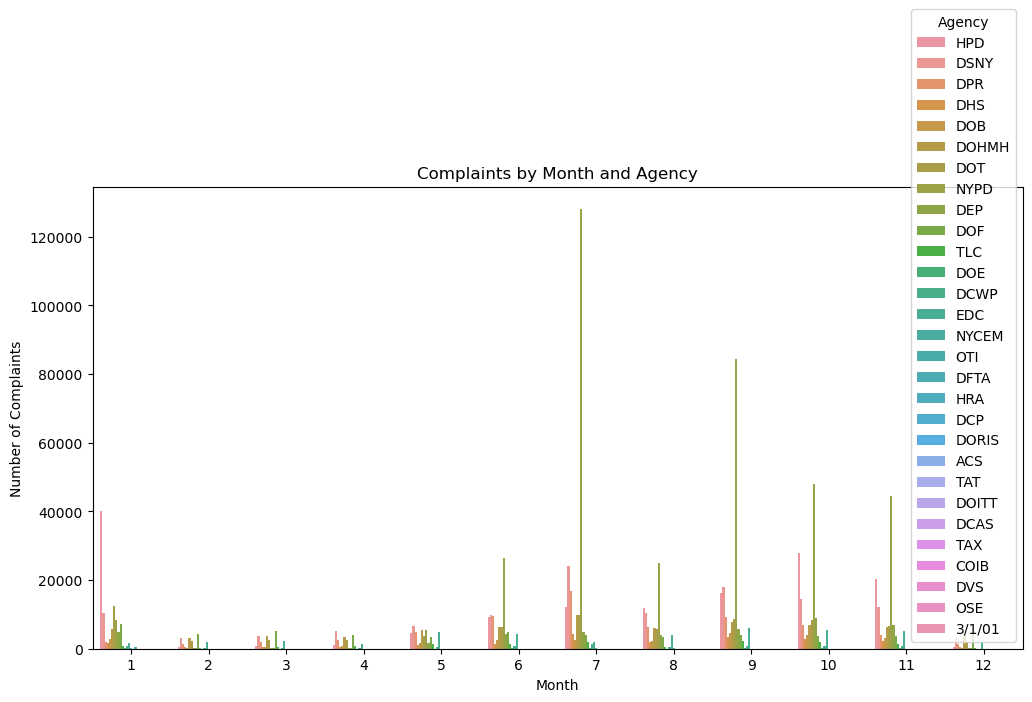

In [14]:
#plotting complaints by month and agency
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Month', hue='Agency')
plt.title('Complaints by Month and Agency')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.show()

In [105]:
#get a better idea of which agencies have more complaints
agency_counts = data['Agency'].value_counts()
print(agency_counts)

Agency
NYPD      371377
HPD       144917
DSNY      120957
DOT        71080
DOHMH      68713
DPR        66794
DOF        52436
DEP        41560
EDC        41323
DOB        25730
DHS        20282
TLC        13568
DCWP        6912
DFTA         791
DOE          672
NYCEM        588
HRA          502
DCAS          94
DOITT         76
ACS           73
OTI           40
TAX           39
OSE           22
DORIS          8
3/1/01         8
DVS            5
DCP            4
TAT            2
COIB           2
Name: count, dtype: int64


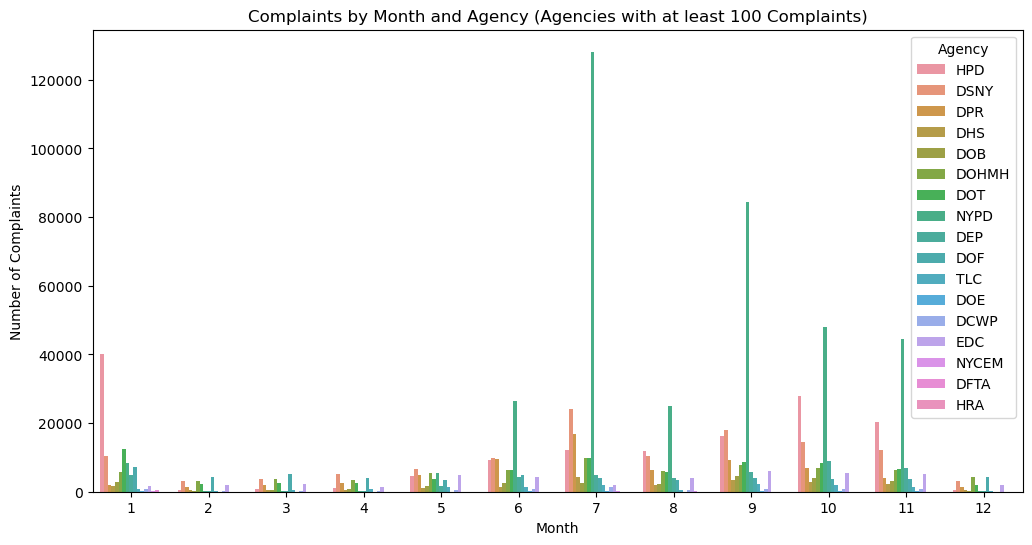

In [132]:
#replot complaints by agency and month, but only ones with at least 100 complaints to see better
#filter out agencies without 100 complaints 
top_agencies = agency_counts[agency_counts >= 100].index

#make sure dataset that's filtered only contains these 
filtered_data = data[data['Agency'].isin(top_agencies)]

#re-plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='Month', hue='Agency')
plt.title('Complaints by Month and Agency (Agencies with at least 100 Complaints)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.show()

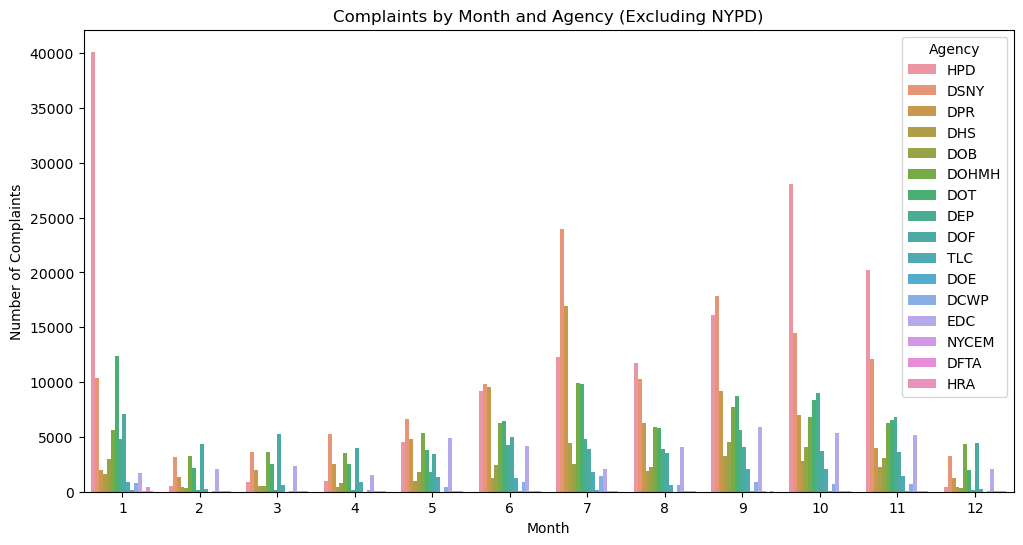

In [19]:
#one last overview/visual, this time getting rid of NYPD data as it's the most concentrated (will come back to it)
#filter out NYPD complaints
filtered_data_without_nypd = filtered_data[filtered_data['Agency'] != 'NYPD']

#plot again
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data_without_nypd, x='Month', hue='Agency')
plt.title('Complaints by Month and Agency (Excluding NYPD)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.show()

In [133]:
#HPD in January is peeking my attention
#filtering for HPD complaints in January
hpd_january_complaints = data[(data['Agency'] == 'HPD') & (data['Month'] == 1)]

#figure out common words, if applicable
from sklearn.feature_extraction.text import CountVectorizer
complaint_texts = hpd_january_complaints['Complaint Type']

#creating a CountVectorizer 
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Adjust max_features as needed
X = vectorizer.fit_transform(complaint_texts)

#converting to DF 
common_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#showing occurrences of each word
word_counts = common_words.sum().sort_values(ascending=False)
print(word_counts)

heating         21260
general          5485
construction     5481
plumbing         4706
plaster          3484
paint            3484
nonconst         2303
electric         1591
appliance         560
request           502
literature        502
hpd               502
condition          76
unsanitary         76
leak               72
water              72
door               30
window             30
flooring           14
stairs             14
dtype: int64


Borough
Unspecified    21252
BRONX              8
BROOKLYN           8
QUEENS             2
MANHATTAN          2
Name: count, dtype: int64


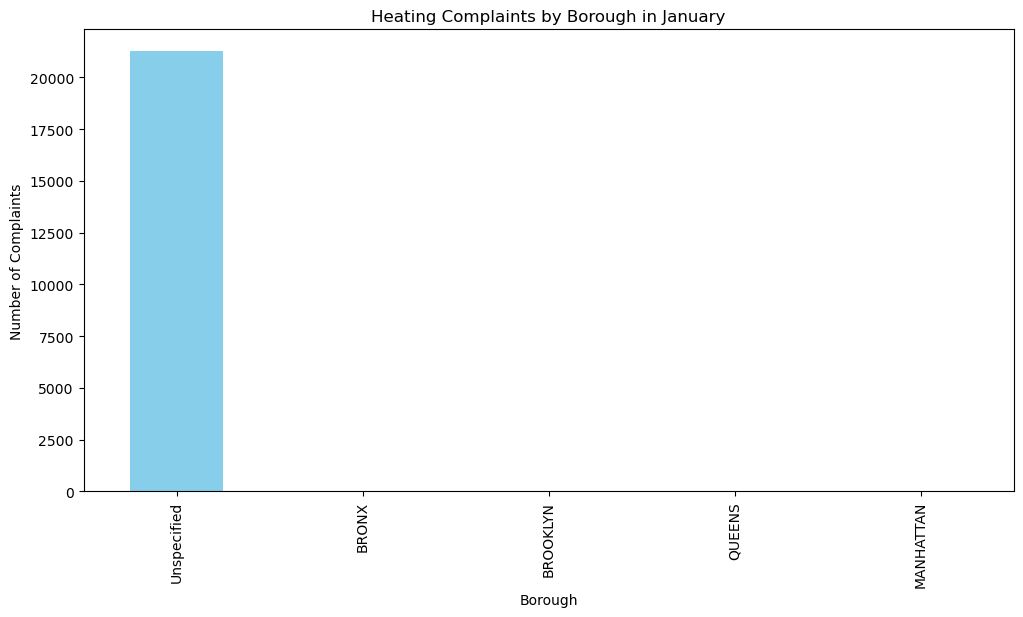

In [106]:
#heating in January seems to be HPD main concern (makes sense)
#now going to see these particular heating complaints by area/borough
#first we define those complaints that are heating-related
heating_complaints = data[data['Complaint Type'].str.contains('heating', case=False, na=False)]

#group complaints (related to heating) by borough
heating_by_borough = heating_complaints['Borough'].value_counts()
print(heating_by_borough)

#visualize
heating_by_borough.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Heating Complaints by Borough in January')
plt.xlabel('Borough')
plt.ylabel('Number of Complaints')
plt.show()

In [22]:
#figure out what's going on w the borough column
#count the number of complaints in each category
print(heating_complaints['Borough'].value_counts())

Borough
Unspecified    21252
BRONX              8
BROOKLYN           8
QUEENS             2
MANHATTAN          2
Name: count, dtype: int64


In [23]:
#further explore "Unspecified" borough heat complaints
unspecified_complaints = heating_complaints[heating_complaints['Borough'] == 'Unspecified']

#see columns to understand other location info available
print(unspecified_complaints[['Incident Zip', 'Street Name', 'Incident Address']].head(10))

       Incident Zip         Street Name        Incident Address
968737        11210       FOSTER AVENUE      3101 FOSTER AVENUE
968739        10466     EAST 233 STREET    1405 EAST 233 STREET
968741        11226     MARTENSE STREET      22 MARTENSE STREET
968745        11212     WILLMOHR STREET    1115 WILLMOHR STREET
968746        11210       FOSTER AVENUE      3103 FOSTER AVENUE
968747        11213      CARROLL STREET     1510 CARROLL STREET
969898        10460  MORRIS PARK AVENUE  441 MORRIS PARK AVENUE
969899        10458     GRAND CONCOURSE    2356 GRAND CONCOURSE
969900        11213      CARROLL STREET     1452 CARROLL STREET
969901        11230        OCEAN AVENUE       1632 OCEAN AVENUE


In [24]:
#figure out "hottest" (no pun intended) zips
zip_counts = unspecified_complaints['Incident Zip'].value_counts()
print(zip_counts.head(25))

Incident Zip
10458    725
10468    697
11226    668
10467    651
10453    634
10456    580
10452    554
11225    544
10457    482
10031    466
10032    464
11213    460
11233    443
10460    436
11212    421
11221    395
11216    335
11207    331
10040    310
10472    295
10033    282
10463    272
10462    269
10459    256
11203    254
Name: count, dtype: int64


In [107]:
#ZIP code to borough mapping #there's probably an easier way to do this but I want to understand it
zip_to_borough = {
    "10001": "Manhattan", "10002": "Manhattan", "10003": "Manhattan", "10004": "Manhattan", "10005": "Manhattan", 
    "10006": "Manhattan", "10007": "Manhattan", "10009": "Manhattan", "10010": "Manhattan", "10011": "Manhattan", 
    "10012": "Manhattan", "10013": "Manhattan", "10014": "Manhattan", "10015": "Manhattan", "10016": "Manhattan", 
    "10017": "Manhattan", "10018": "Manhattan", "10019": "Manhattan", "10020": "Manhattan", "10021": "Manhattan", 
    "10022": "Manhattan", "10023": "Manhattan", "10024": "Manhattan", "10025": "Manhattan", "10026": "Manhattan", 
    "10027": "Manhattan", "10028": "Manhattan", "10029": "Manhattan", "10030": "Manhattan", "10031": "Manhattan", 
    "10032": "Manhattan", "10033": "Manhattan", "10034": "Manhattan", "10035": "Manhattan", "10036": "Manhattan", 
    "10037": "Manhattan", "10038": "Manhattan", "10039": "Manhattan", "10040": "Manhattan", "10041": "Manhattan", 
    "10044": "Manhattan", "10045": "Manhattan", "10048": "Manhattan", "10055": "Manhattan", "10060": "Manhattan", 
    "10069": "Manhattan", "10090": "Manhattan", "10095": "Manhattan", "10098": "Manhattan", "10099": "Manhattan", 
    "10103": "Manhattan", "10104": "Manhattan", "10105": "Manhattan", "10106": "Manhattan", "10107": "Manhattan", 
    "10110": "Manhattan", "10111": "Manhattan", "10112": "Manhattan", "10115": "Manhattan", "10118": "Manhattan", 
    "10119": "Manhattan", "10120": "Manhattan", "10121": "Manhattan", "10122": "Manhattan", "10123": "Manhattan", 
    "10128": "Manhattan", "10151": "Manhattan", "10152": "Manhattan", "10153": "Manhattan", "10154": "Manhattan", 
    "10155": "Manhattan", "10158": "Manhattan", "10161": "Manhattan", "10162": "Manhattan", "10165": "Manhattan", 
    "10166": "Manhattan", "10167": "Manhattan", "10168": "Manhattan", "10169": "Manhattan", "10170": "Manhattan", 
    "10171": "Manhattan", "10172": "Manhattan", "10173": "Manhattan", "10174": "Manhattan", "10175": "Manhattan", 
    "10176": "Manhattan", "10177": "Manhattan", "10178": "Manhattan", "10199": "Manhattan", "10270": "Manhattan", 
    "10271": "Manhattan", "10278": "Manhattan", "10279": "Manhattan", "10280": "Manhattan", "10281": "Manhattan", 
    "10282": "Manhattan", "10301": "Staten", "10302": "Staten", "10303": "Staten", "10304": "Staten", "10305": "Staten", 
    "10306": "Staten", "10307": "Staten", "10308": "Staten", "10309": "Staten", "10310": "Staten", "10311": "Staten", 
    "10312": "Staten", "10314": "Staten", "10451": "Bronx", "10452": "Bronx", "10453": "Bronx", "10454": "Bronx", 
    "10455": "Bronx", "10456": "Bronx", "10457": "Bronx", "10458": "Bronx", "10459": "Bronx", "10460": "Bronx", 
    "10461": "Bronx", "10462": "Bronx", "10463": "Bronx", "10464": "Bronx", "10465": "Bronx", "10466": "Bronx", 
    "10467": "Bronx", "10468": "Bronx", "10469": "Bronx", "10470": "Bronx", "10471": "Bronx", "10472": "Bronx", 
    "10473": "Bronx", "10474": "Bronx", "10475": "Bronx", "11004": "Queens", "11101": "Queens", "11102": "Queens", 
    "11103": "Queens", "11104": "Queens", "11105": "Queens", "11106": "Queens", "11109": "Queens", "11201": "Brooklyn", 
    "11203": "Brooklyn", "11204": "Brooklyn", "11205": "Brooklyn", "11206": "Brooklyn", "11207": "Brooklyn", "11208": "Brooklyn", 
    "11209": "Brooklyn", "11210": "Brooklyn", "11211": "Brooklyn", "11212": "Brooklyn", "11213": "Brooklyn", "11214": "Brooklyn", 
    "11215": "Brooklyn", "11216": "Brooklyn", "11217": "Brooklyn", "11218": "Brooklyn", "11219": "Brooklyn", "11220": "Brooklyn", 
    "11221": "Brooklyn", "11222": "Brooklyn", "11223": "Brooklyn", "11224": "Brooklyn", "11225": "Brooklyn", "11226": "Brooklyn", 
    "11228": "Brooklyn", "11229": "Brooklyn", "11230": "Brooklyn", "11231": "Brooklyn", "11232": "Brooklyn", "11233": "Brooklyn", 
    "11234": "Brooklyn", "11235": "Brooklyn", "11236": "Brooklyn", "11237": "Brooklyn", "11238": "Brooklyn", "11239": "Brooklyn", 
    "11241": "Brooklyn", "11242": "Brooklyn", "11243": "Brooklyn", "11249": "Brooklyn", "11252": "Brooklyn", "11256": "Brooklyn", 
    "11351": "Queens", "11354": "Queens", "11355": "Queens", "11356": "Queens", "11357": "Queens", "11358": "Queens", 
    "11359": "Queens", "11360": "Queens", "11361": "Queens", "11362": "Queens", "11363": "Queens", "11364": "Queens", 
    "11365": "Queens", "11366": "Queens", "11367": "Queens", "11368": "Queens", "11369": "Queens", "11370": "Queens", 
    "11371": "Queens", "11372": "Queens", "11373": "Queens", "11374": "Queens", "11375": "Queens", "11377": "Queens", 
    "11378": "Queens", "11379": "Queens", "11385": "Queens", "11411": "Queens", "11412": "Queens", "11413": "Queens", 
    "11414": "Queens", "11415": "Queens", "11416": "Queens", "11417": "Queens", "11418": "Queens", "11419": "Queens", 
    "11420": "Queens", "11421": "Queens", "11422": "Queens", "11423": "Queens", "11426": "Queens", "11427": "Queens", 
    "11428": "Queens", "11429": "Queens", "11430": "Queens", "11432": "Queens", "11433": "Queens", "11434": "Queens", 
    "11435": "Queens", "11436": "Queens", "11691": "Queens", "11692": "Queens", "11693": "Queens", "11694": "Queens", 
    "11695": "Queens", "11697": "Queens"
}

#converting to df
borough_df = pd.DataFrame(list(zip(zip_to_borough.keys(), zip_to_borough.values())), columns=["ZIP Code", "Borough"])

     Borough  Complaint Count
1   Brooklyn            13679
0      Bronx            12813
2  Manhattan             7529
3     Queens             4807
4     Staten              666


<Figure size 1000x600 with 0 Axes>

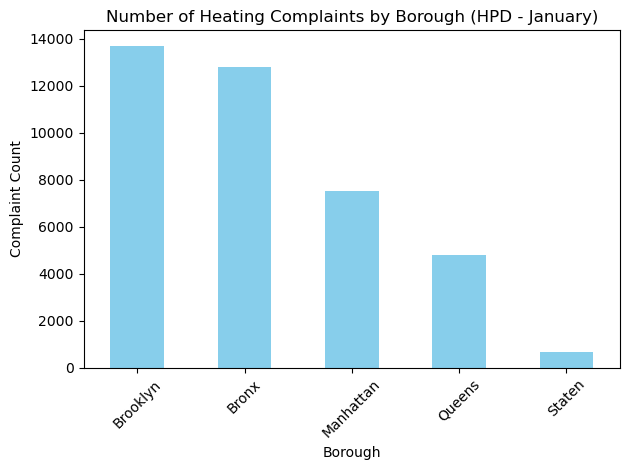

In [110]:
#make sure I'm properly updating the 'borough' column
hpd_january_complaints = hpd_january_complaints.copy()
hpd_january_complaints['Borough'] = hpd_january_complaints['Incident Zip'].map(zip_to_borough)

#remove null rows 
hpd_january_complaints = hpd_january_complaints.dropna(subset=['Borough'])

#group by borough and count the number of complaints
borough_complaints = hpd_january_complaints.groupby('Borough').size().reset_index(name='Complaint Count')

#sort by complaint count
borough_complaints = borough_complaints.sort_values(by='Complaint Count', ascending=False)

#printresults
print(borough_complaints)

#also plot a visual 
plt.figure(figsize=(10, 6))
borough_complaints.plot(kind='bar', x='Borough', y='Complaint Count', color='skyblue', legend=False)
plt.title('Number of Heating Complaints by Borough (HPD - January)')
plt.xlabel('Borough')
plt.ylabel('Complaint Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#takeaway is that Brooklyn and Bronx may need additional personell - both proactively and during these chilly months - to cut back on complaints
    #maybe take a look at "what's working" in Staten island (ratio of workers to units, effective servicing companies, etc.) (further analysis routes)

In [32]:
#reset/make sure data is defined correctly
data = pd.read_csv("311_Service_Requests.csv", low_memory=False)

#calculate percentage of ALL complaints that are heating complaints in January
total_all_complaints = len(data)  
heating_january_complaints = len(hpd_january_complaints) 
heating_percentage = (heating_january_complaints / total_all_complaints) * 100
print(f"Percentage of Heating Complaints in January (out of ALL complaints): {heating_percentage:.2f}%")

Percentage of Heating Complaints in January (out of ALL complaints): 3.77%


In [134]:
#4% of ALL complaints (2010 - present) being HEATING complaints in JANUARY is remarkable 
#continuing analysis
#pivoting now to the DSNY [sanitation complaints, which was third most common agency behind HPD]
dsny_complaints = data[data['Agency'] == 'DSNY']

#extract 'Complaint Type' column for DSNY agency complaints
complaint_texts2 = dsny_complaints['Complaint Type']

#create another CountVectorizer 
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Change max_features if needed
X = vectorizer.fit_transform(complaint_texts2)

#convert to dataframe
common_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#total occurence of each common word
word_counts = common_words.sum().sort_values(ascending=False)
print(word_counts)

request        29628
literature     25463
condition      19053
derelict       18681
vehicles       18653
dirty          17751
illegal        11330
collection     10855
dumping        10289
graffiti        7938
missed          7873
complaint       7323
enforcement     7080
vendor          6781
obstruction     5508
disposal        3592
sanitation      3104
large           3064
item            3064
bulky           3064
dtype: int64


In [111]:
#one word repeats are not particularly helpful, so going to try by 2-word phrases
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=20)  # Adjust max_features as needed
X = vectorizer.fit_transform(complaint_texts2)

#convert yet again to a DF 
common_ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#calculate common occurrences 
ngram_counts = common_ngrams.sum().sort_values(ascending=False)
print(ngram_counts)

literature request      25463
derelict vehicles       18653
dirty condition         15888
illegal dumping         10289
missed collection        7775
vendor enforcement       6781
disposal complaint       3592
bulky item               3064
request large            3064
large bulky              3064
item collection          3064
residential disposal     2929
dead animal              2576
sanitation condition     2472
street sweeping          2170
sweeping complaint       2170
dirty conditions         1863
litter basket            1521
collection materials     1211
basket request           1096
dtype: int64


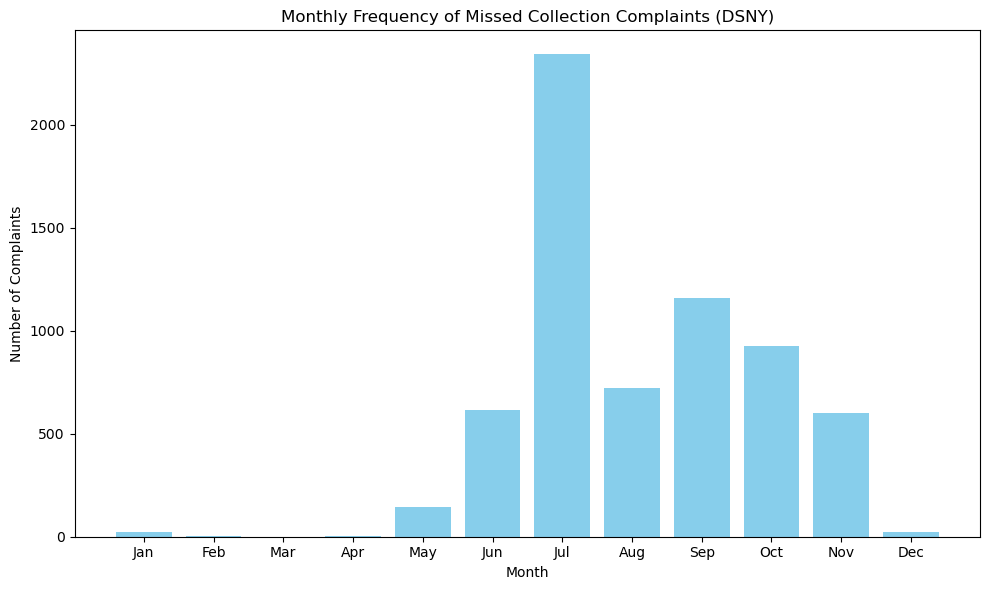

In [135]:
#going to focus in on "missed collection" complaints to DSNY 
missed_collection_complaints = dsny_complaints[dsny_complaints['Complaint Type'] == 'Missed Collection'].copy()

#convert 'Created Date' to datetime using specific format [ran print statements prev. to realize '24 vs. 2024 was issue]
missed_collection_complaints['Created Date'] = pd.to_datetime(
    missed_collection_complaints['Created Date'], 
    format='%m/%d/%y %H:%M',  # New date format
    errors='coerce'  # Coerce errors into NaT
)

#extract month from 'created date' column
missed_collection_complaints['Month'] = missed_collection_complaints['Created Date'].dt.month

#group by month and count the occurrences
monthly_missed_collection = missed_collection_complaints.groupby('Month').size().reset_index(name='Complaint Count')

#plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_missed_collection['Month'], monthly_missed_collection['Complaint Count'], color='skyblue')
plt.title('Monthly Frequency of Missed Collection Complaints (DSNY)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

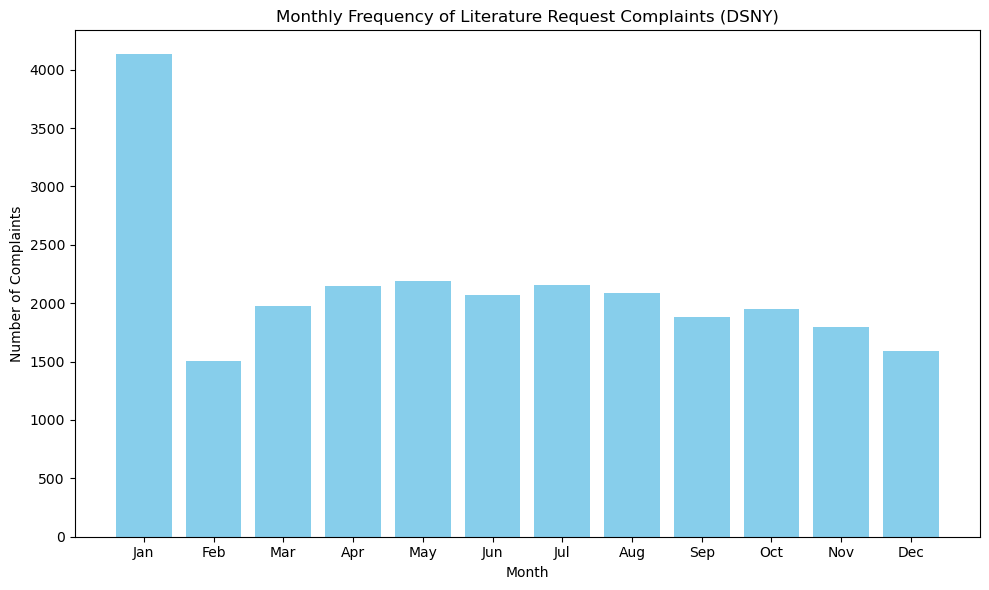

In [136]:
#takeaway relating to unproportionately high July complaints and not having trash picked up

#now going to look at reoccurence for "literature request" - specifically across the 12 months 
#first filter for 'literature request' complaints 
literature_requests = dsny_complaints[dsny_complaints['Complaint Type'].str.contains("literature request", case=False, na=False)].copy()

#convert to datetime format that's analyzable
literature_requests['Created Date'] = pd.to_datetime(
    literature_requests['Created Date'], 
    format='%m/%d/%y %H:%M',  # Adjust format based on your dataset's actual date format
    errors='coerce'  # Coerce errors into NaT
)

#determine & group by month
literature_requests.loc[:, 'Month'] = literature_requests['Created Date'].dt.month  # Use .loc to set the column
monthly_literature_requests = literature_requests.groupby('Month').size().reset_index(name='Complaint Count')

#plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_literature_requests['Month'], monthly_literature_requests['Complaint Count'], color='skyblue')
plt.title('Monthly Frequency of Literature Request Complaints (DSNY)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

In [137]:
#recognizing the heavy proportion of liteature requests come in during January
#going to further examine this month for composition of requests
#begin by filtering for 'literature request' complaints within DSNY, within January
literature_requests_january = dsny_complaints[
    (dsny_complaints['Complaint Type'].str.contains("literature request", case=False, na=False)) & 
    (dsny_complaints['Created Date'].dt.month == 1)
].copy()  #trying to avoid the SettingWithCopyWarning

#ensure datetime format
if not pd.api.types.is_datetime64_any_dtype(literature_requests_january['Created Date']):
    literature_requests_january['Created Date'] = pd.to_datetime(
        literature_requests_january['Created Date'], 
        format='%m/%d/%y %H:%M',  
        errors='coerce'  #dealing with invalid entries
    )

In [138]:
#we NOW have  literature requests from January
#going to focus on common words
#specifically using the 'Descriptor' column for analysis
complaint_texts_january = literature_requests_january['Descriptor']  

#find the most common words (not counting 'literature' and 'request')
vectorizer = CountVectorizer(stop_words='english', max_features=20)  
X = vectorizer.fit_transform(complaint_texts_january)

#convert to DF
common_words_january = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

#calculate occurences
word_counts_january = common_words_january.sum().sort_values(ascending=False)
print("Common words in 'Literature Request' complaints for January:")
print(word_counts_january)

#analyze 2 word phrases
vectorizer_ngrams = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=20)  # 2-word n-grams
X_ngrams = vectorizer_ngrams.fit_transform(complaint_texts_january)

#convert to DF
common_ngrams_january = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer_ngrams.get_feature_names_out())

#occurence of 2 word phrases
ngram_counts_january = common_ngrams_january.sum().sort_values(ascending=False)
print("\nCommon 2-word phrases in 'Literature Request' complaints for January:")
print(ngram_counts_january)

Common words in 'Literature Request' complaints for January:
recycling     2107
decal         1225
blue          1093
green         1045
mixed         1044
decals        1044
paper         1044
checklist      597
flyer          540
lit            537
request        537
literature     537
sticker        214
bldg           194
removable      193
poster         172
area           131
digest          97
codes           97
owner           52
dtype: int64

Common 2-word phrases in 'Literature Request' complaints for January:
blue recycling         1092
recycling decal        1092
mixed paper            1044
green mixed            1044
paper decals           1044
recycling checklist     597
lit literature          537
literature request      537
checklist flyer         404
checklist removable     193
removable sticker       193
bldg poster             162
recycling bldg          162
recycling area          131
area decal              131
digest codes             97
recycle wasteless        50

In [139]:
#above analysis sounds somewhat familiar (literature request &&missed collection)
#takeaway is more recycling/DSNY personell as a whole are needed in month of January 

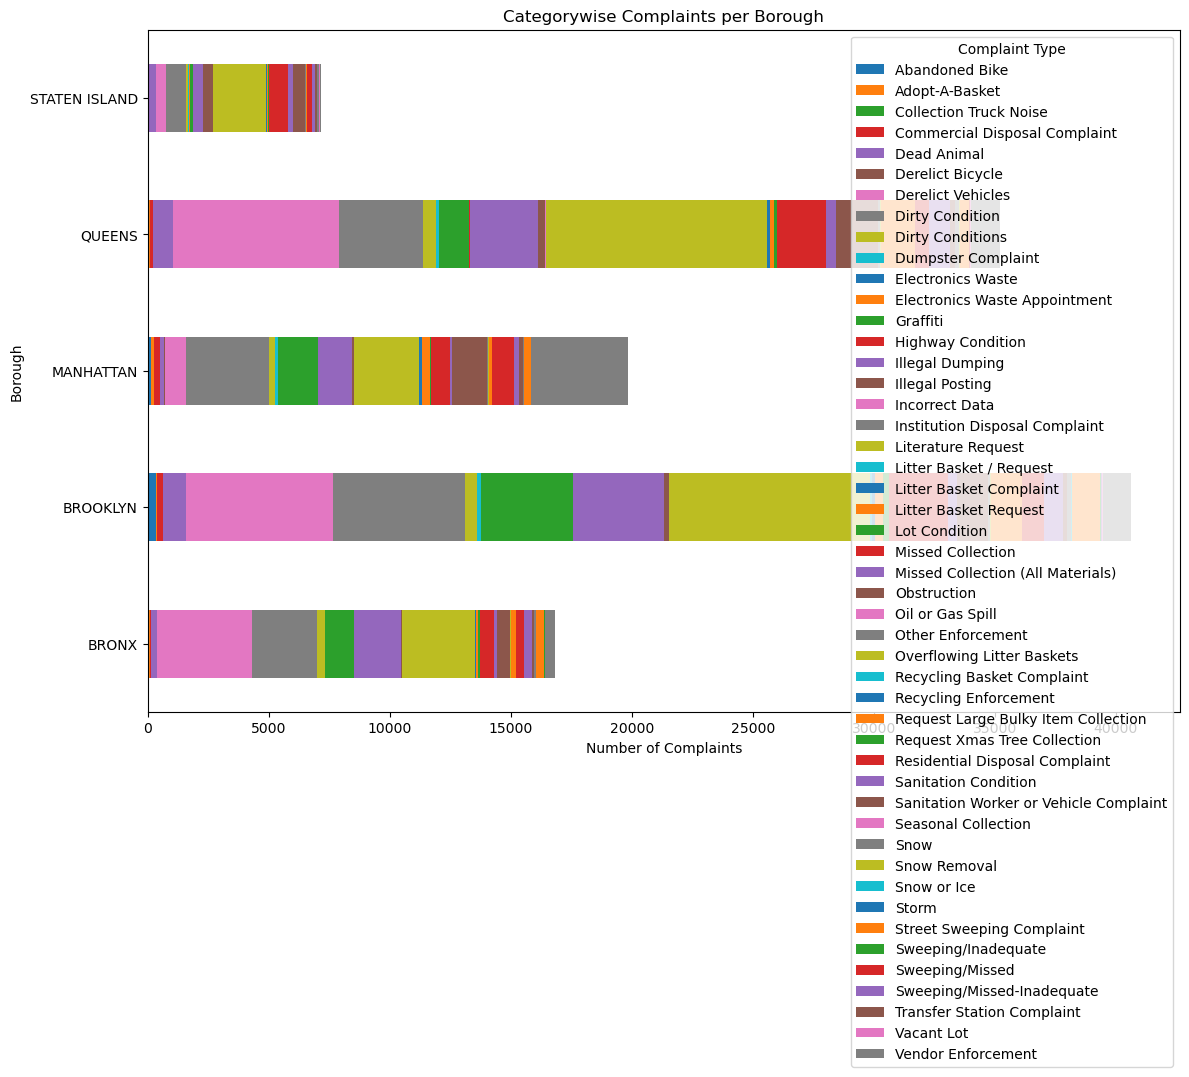

In [36]:
#zooming back out to try to create a stacked bar chart w/ the 5 boroughs
the5boroughs = dsny_complaints['Borough'].value_counts().head(5).index.to_list()
dstop5boroughs = dsny_complaints[dsny_complaints['Borough'].isin(the5boroughs)]

#create a category complaint count per borough
borough_complaint_counts = pd.crosstab(dstop5boroughs['Borough'], dstop5boroughs['Complaint Type'])

#plot
borough_complaint_counts.plot(kind='barh', stacked=True, figsize=(12, 10))
plt.title('Categorywise Complaints per Borough')
plt.xlabel('Number of Complaints')
plt.ylabel('Borough')
plt.tight_layout()
plt.show()

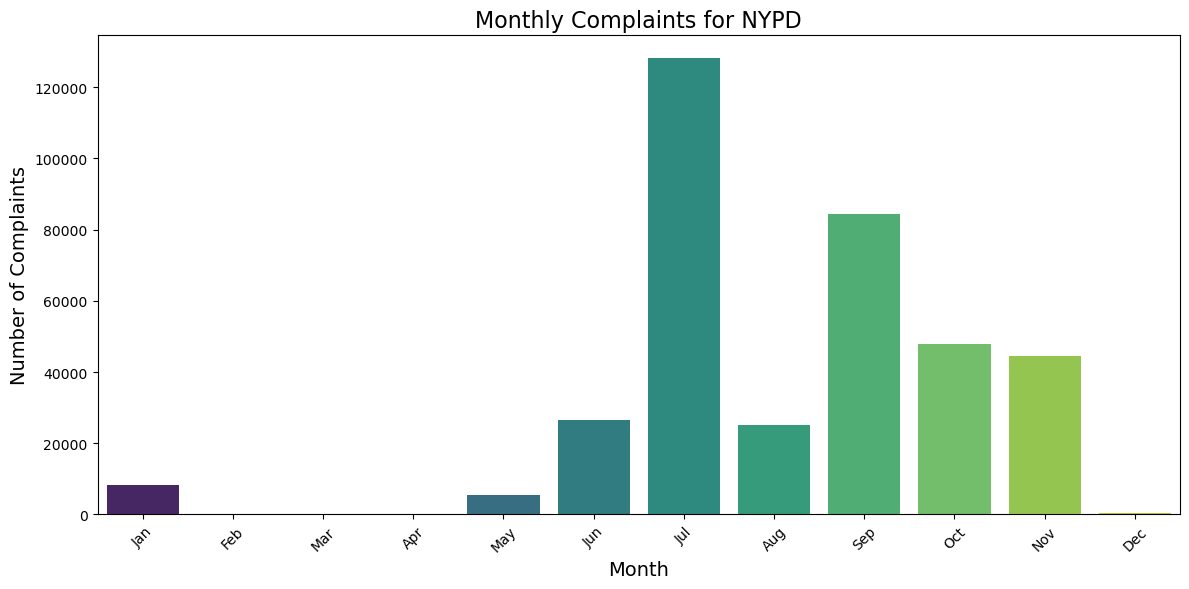

In [141]:
#there are lots of ideas of analysis I have, below i've stated a few, but going to wrap it up...
    #specific location concentration of derelict vehicles (using street names, intersections, etc.)
    #whats going on w Xmas tree collection, specifically in Brooklyn (high, it appears)
    #timing of complaint resolution per complaint type or location
    #weighting of most common, i.e. 8, complaints per borough (see which complaints are more common where) 
#I could play with this data forever, so instead, we are NOW going to recircle back to NYPD complaints:
#focus on NYPD complaints (top Agency, above Sanitation and HPD)
nypd_complaints = data[data['Agency'] == 'NYPD'].copy()

#datetime formatting again
nypd_complaints['Created Date'] = pd.to_datetime(
    nypd_complaints['Created Date'], 
    format='%m/%d/%y %H:%M',  #=(mm/dd/yy)
    errors='coerce'  
)
nypd_complaints['Month'] = nypd_complaints['Created Date'].dt.month

#count number of complaints per month
plt.figure(figsize=(12, 6))
sns.countplot(data=nypd_complaints, x='Month', palette='viridis')

#add labels
plt.title('Monthly Complaints for NYPD', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()

#plot
plt.show()

In [124]:
#july is very high
#going to determine the % of all NYPD complaints that fall in July
total_nypd_complaints = nypd_complaints.shape[0]

#number of NYPD complaints in july 
july_complaints = nypd_complaints[nypd_complaints['Month'] == 7].shape[0]

#calculate the percentage 
percentage_july_complaints = (july_complaints / total_nypd_complaints) * 100
print(f"Percentage of total NYPD complaints in July: {percentage_july_complaints:.2f}%")

Percentage of total NYPD complaints in July: 34.52%


In [127]:
#more than one third of all complaints are in ONE month (statistically/averagely, this "should be" around 7-9%
#what is going on in July?
#see if spike in July complaints is concentrated in particular location

#define july complaints
july_complaints = nypd_complaints[nypd_complaints['Month'] == 7]
july_complaints_location = july_complaints[['Location Type', 'Borough', 'Incident Address']].dropna()
location_counts = july_complaints_location.groupby(['Borough', 'Location Type']).size().reset_index(name='Count')
print(location_counts)

          Borough               Location Type  Count
0           BRONX         Club/Bar/Restaurant     79
1           BRONX                  Commercial      1
2           BRONX                 Common Area      9
3           BRONX                     Hallway     23
4           BRONX            House of Worship      9
..            ...                         ...    ...
72  STATEN ISLAND             Street/Sidewalk   2820
73  STATEN ISLAND                  Vacant Lot      3
74    Unspecified         Club/Bar/Restaurant      1
75    Unspecified  Residential Building/House      3
76    Unspecified             Street/Sidewalk     27

[77 rows x 3 columns]


In [129]:
#top 5 locations
location_counts_sorted = location_counts.sort_values(by='Count', ascending=False)
print(location_counts_sorted.head(5))  

      Borough               Location Type  Count
26   BROOKLYN             Street/Sidewalk  27891
59     QUEENS             Street/Sidewalk  26498
12      BRONX             Street/Sidewalk  19037
42  MANHATTAN             Street/Sidewalk  15413
23   BROOKLYN  Residential Building/House   8165


In [ ]:
#Street/sidewalk "issues" to NYPD are clear frontrunner
#Brooklyn is also deduced as "most" problematic (on a calls to NYPD basis) (could be reflecting lack of personel or resources per capita)
#takeaway is to have some Manhattan patrollers stationed in Brooklyn, Queens, Bronx (in that order) during summer months
#could be due to increased construction in summer, heat/temperature, July 4, festivals or parades, etc.

In [142]:
#dive deeper into street/sidewalk complaint composition
street_sidewalk_complaints = july_complaints[july_complaints['Location Type'] == 'Street/Sidewalk']

#count occurence of each complaint type
complaint_type_counts = street_sidewalk_complaints['Complaint Type'].value_counts().reset_index()
complaint_type_counts.columns = ['Complaint Type', 'Count']

#sort 
complaint_type_counts_sorted = complaint_type_counts.sort_values(by='Count', ascending=False)
print(complaint_type_counts_sorted.head(10))  # Top 10 Complaint Types

                Complaint Type  Count
0              Illegal Parking  36758
1      Noise - Street/Sidewalk  21318
2             Blocked Driveway  11991
3            Abandoned Vehicle   5538
4            Illegal Fireworks   4306
5              Noise - Vehicle   3814
6                Drug Activity   2886
7                   Encampment   1643
8  Non-Emergency Police Matter   1126
9                      Traffic    907


In [165]:
#create stacked chart for composition of complaints to NYPD per month

#count occurences
monthly_complaints = nypd_complaints[['Month', 'Complaint Type']].dropna()
monthly_complaints_count = monthly_complaints.groupby(['Month', 'Complaint Type']).size().reset_index(name='Count')

#focus on top 7 complaint types for each month
monthly_complaints_count['Rank'] = monthly_complaints_count.groupby('Month')['Count'].rank(method='first', ascending=False)
top_7_complaints_all_months = monthly_complaints_count[monthly_complaints_count['Rank'] <= 7]

#all months need to be represented
months = np.arange(1, 13)
top_7_complaints_all_months = top_7_complaints_all_months.merge(pd.DataFrame({'Month': months}), on='Month', how='outer')

# pivot for visuals
pivot_table_all_months = top_7_complaints_all_months.pivot(index='Month', columns='Complaint Type', values='Count').fillna(0)

#prevent division by zero errors by adding tiny value
pivot_table_all_months += 1e-6  

#re-calculate total complaints per month 
pivot_table_all_months['Total Complaints'] = pivot_table_all_months.sum(axis=1)

# % composition of each complaint type
percentage_composition = pivot_table_all_months.drop(columns='Total Complaints').div(pivot_table_all_months['Total Complaints'], axis=0) * 100

#calculate averages 
average_composition = percentage_composition.mean(axis=0)

#calculate s.d.'s
std_deviation_composition = percentage_composition.std(axis=0)

#print
print("Average Composition (%) per Complaint Type:")
print(average_composition)

print("\nStandard Deviation of Composition (%) per Complaint Type:")
print(std_deviation_composition)


Average Composition (%) per Complaint Type:
Complaint Type
Abandoned Vehicle           4.057594
Blocked Driveway           11.076225
Derelict Vehicle            1.001914
Encampment                 14.921632
Illegal Fireworks           0.504708
Illegal Parking            27.382923
Noise - Commercial          3.510888
Noise - Park                1.572327
Noise - Residential        18.641436
Noise - Street/Sidewalk    10.075906
Noise - Vehicle             2.271422
Panhandling                 2.428361
Traffic                     1.517653
Traffic/Illegal Parking     1.037009
dtype: float64

Standard Deviation of Composition (%) per Complaint Type:
Complaint Type
Abandoned Vehicle           2.205616
Blocked Driveway            4.945763
Derelict Vehicle            2.344751
Encampment                 21.840186
Illegal Fireworks           1.748360
Illegal Parking            10.939073
Noise - Commercial          2.683528
Noise - Park                5.446700
Noise - Residential        14.455171
N

In [ ]:
#encampment has highest s.d., indicating varying month-to-month (makes sense w/ seasonality)
#noise (residential in particular) & illegal parking also have high s.d.'s (no consistent month-to-month pattern)
#overall, majority of NYPD complaints concern illegal parking and noise
#blocked driveway is also salient
#complaints (i.e. blocked driveway) with high avg and low s.d. thus show ongoing (predictable) issues
#attempt to address with increased signage, fines, etc. (as opposed to 'unpredictable' complaints that may require more flexible apporach)

In [ ]:
#the thought process, debugging, and overall train of analysis above is all mine (I received no help) 
#my coding was largely back-ended (figured out specific areas for learning as I went along)
    #I was very creative and resourceful in this
#please let me know if there are any questions or feedback. Thank you! 